In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob 
import segmenteverygrain as seg
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [76]:
from importlib import reload
reload(seg)

<module 'segmenteverygrain' from '/Users/zoltan/Dropbox/Segmentation/segmenteverygrain/segmenteverygrain/segmenteverygrain.py'>

## Create patches from large images

In [61]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
images = sorted(glob(dirname + "*image*"))
labels = sorted(glob(dirname + "*mask*"))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = image_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]
    
start_no = 0
for image in tqdm(labels):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = large_image[:,:,0,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname = mask_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [11:45<00:00, 18.08s/it]


## Create training, validation, and test sets

In [77]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

batch_size = 32
shuffle_buffer_size = 1000

# split half into training
train_idx = np.random.choice(np.arange(len(image_files)), size = int(len(image_files)/2) , replace=False)
# get the rest
idx = np.setdiff1d(np.arange(len(image_files)), train_idx)
# get val files (25% of total)
val_idx = np.random.choice(idx, size = int(len(image_files)/4) , replace=False)
# get test files (25% of total)
test_idx = np.setdiff1d(val_idx, train_idx)

# create arrays of training, validation, and test files (these are filenames)
train_images = np.array(image_files)[train_idx]
val_images = np.array(image_files)[val_idx]
test_images = np.array(image_files)[test_idx]

train_masks = np.array(mask_files)[train_idx]
val_masks = np.array(mask_files)[val_idx]
test_masks = np.array(mask_files)[test_idx]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

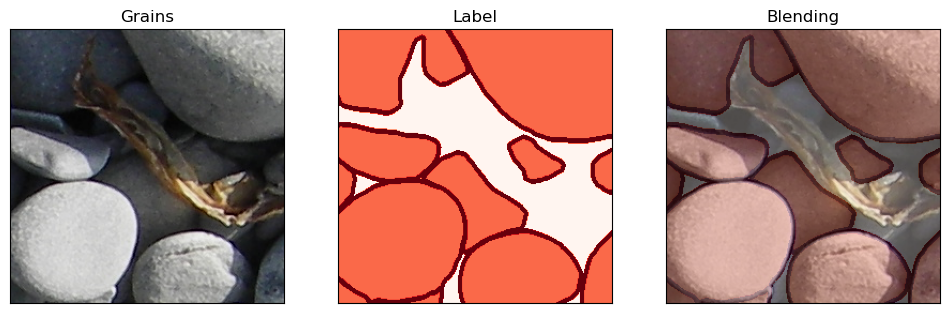

In [79]:
# check how masks look like
fname = train_images[5800]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # need to convert from BGR to RGB
mask = cv2.imread(fname.replace('images', 'labels'))
seg.plot_images_and_labels(img, mask)

## Build, train, and evaluate model

In [80]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 concatenate_2 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'batch_normalization_1[0][0]']  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 rmalizati

In [81]:
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100


2023-06-02 06:15:33.029419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.9622 - accuracy: 0.6587

2023-06-02 06:16:07.181197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 42s 189ms/step - loss: 0.9622 - accuracy: 0.6587 - val_loss: 1.3080 - val_accuracy: 0.4728
Epoch 2/100
191/191 [==============================] - 34s 174ms/step - loss: 0.8579 - accuracy: 0.7781 - val_loss: 1.0433 - val_accuracy: 0.6892
Epoch 3/100
191/191 [==============================] - 34s 176ms/step - loss: 0.8329 - accuracy: 0.8039 - val_loss: 0.8832 - val_accuracy: 0.7986
Epoch 4/100
191/191 [==============================] - 34s 175ms/step - loss: 0.8117 - accuracy: 0.8284 - val_loss: 0.8184 - val_accuracy: 0.8306
Epoch 5/100
191/191 [==============================] - 33s 174ms/step - loss: 0.7962 - accuracy: 0.8456 - val_loss: 0.9101 - val_accuracy: 0.6501
Epoch 6/100
191/191 [==============================] - 34s 176ms/step - loss: 0.7853 - accuracy: 0.8574 - val_loss: 0.8455 - val_accuracy: 0.7844
Epoch 7/100
191/191 [==============================] - 34s 175ms/step - loss: 0.7840 - accuracy: 0.8585 - val_loss: 0.8744 - val_accurac

Epoch 57/100
191/191 [==============================] - 33s 174ms/step - loss: 0.6764 - accuracy: 0.9590 - val_loss: 0.7110 - val_accuracy: 0.9436
Epoch 58/100
191/191 [==============================] - 33s 171ms/step - loss: 0.6789 - accuracy: 0.9567 - val_loss: 0.7212 - val_accuracy: 0.9351
Epoch 59/100
191/191 [==============================] - 33s 172ms/step - loss: 0.6768 - accuracy: 0.9587 - val_loss: 0.7078 - val_accuracy: 0.9450
Epoch 60/100
191/191 [==============================] - 33s 172ms/step - loss: 0.6735 - accuracy: 0.9618 - val_loss: 0.7069 - val_accuracy: 0.9467
Epoch 61/100
191/191 [==============================] - 33s 172ms/step - loss: 0.6758 - accuracy: 0.9596 - val_loss: 0.7072 - val_accuracy: 0.9437
Epoch 62/100
191/191 [==============================] - 33s 171ms/step - loss: 0.6742 - accuracy: 0.9612 - val_loss: 0.7058 - val_accuracy: 0.9454
Epoch 63/100
191/191 [==============================] - 33s 171ms/step - loss: 0.6724 - accuracy: 0.9628 - val_loss: 0

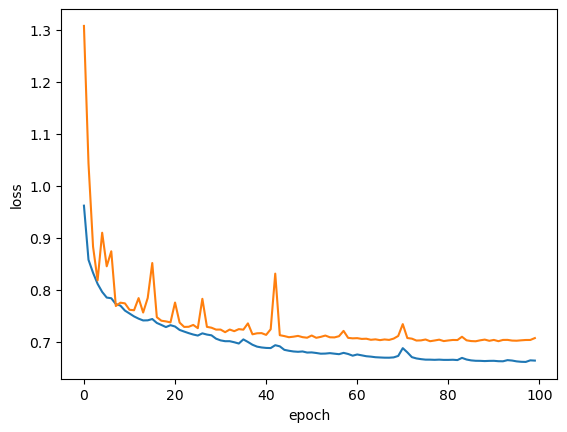

In [82]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss');
# plt.xlim([50,200])
# plt.ylim([0.685, 0.700]);

Text(0, 0.5, 'accuracy')

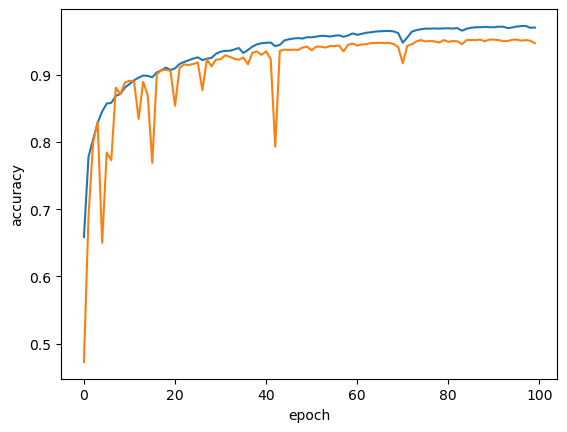

In [83]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.xlim([100,200])
# plt.ylim([0.95, 0.985])

In [42]:
model.evaluate(test_dataset)

89/89 [==============================] - 5s 57ms/step - loss: 0.6869 - accuracy: 0.9620


[0.6868884563446045, 0.9619690775871277]

In [43]:
model.save_weights('seg_model')